In [1]:
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('wordnet')

df = pd.read_csv("../data/fulldata.csv")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Andrew\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from Cleaning import lowercase, unpunctuate, tokenize, lemmatize, count_capitalized_words, create_other_var, cleaning_and_prep, stack_vectors

In [3]:
X_train, X_test, y_train, y_test = cleaning_and_prep(df)

C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
C:\Users\Andrew\Documents\LHL\PoliticalNLP\python\Cleaning.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Political Lean'] = df['Political Lean'].replace('Conservative',0)


In [4]:
X_train_vec, X_test_vec, X_train, X_test = stack_vectors(X_train,X_test)

In [5]:
X_train = X_train[:,0:4]
X_test = X_test[:,0:4]

Epoch 1/100
433/433 [==============================] - 16s 28ms/step - loss: 0.6439 - accuracy: 0.6131 - auc: 0.6680 - val_loss: 0.6086 - val_accuracy: 0.6560 - val_auc: 0.7311
Epoch 2/100
433/433 [==============================] - 10s 23ms/step - loss: 0.5989 - accuracy: 0.6651 - auc: 0.7347 - val_loss: 0.5822 - val_accuracy: 0.6994 - val_auc: 0.7787
Epoch 3/100
433/433 [==============================] - 9s 20ms/step - loss: 0.5770 - accuracy: 0.6831 - auc: 0.7643 - val_loss: 0.5680 - val_accuracy: 0.6830 - val_auc: 0.7852
Epoch 4/100
433/433 [==============================] - 7s 17ms/step - loss: 0.5672 - accuracy: 0.6893 - auc: 0.7715 - val_loss: 0.5558 - val_accuracy: 0.7108 - val_auc: 0.7881
Epoch 5/100
433/433 [==============================] - 7s 17ms/step - loss: 0.5608 - accuracy: 0.6985 - auc: 0.7808 - val_loss: 0.5555 - val_accuracy: 0.6994 - val_auc: 0.7860
Epoch 6/100
433/433 [==============================] - 7s 17ms/step - loss: 0.5552 - accuracy: 0.7031 - auc: 0.7839 - 

<Axes: >

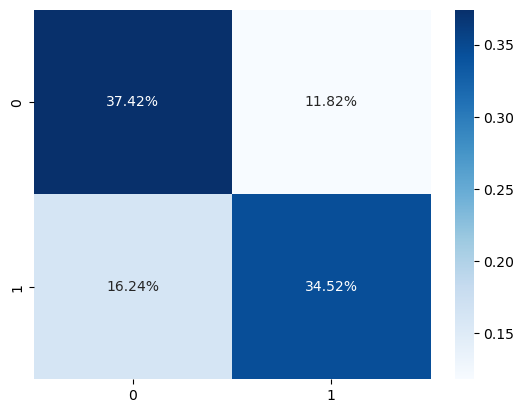

In [6]:
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input, concatenate
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

# First branch for the LSTM
lstm_input = Input(shape=(1, 100))
lstm_output = LSTM(units=256, return_sequences=True, activation='relu')(lstm_input)
lstm_output = Dropout(0.2)(lstm_output)
lstm_output = LSTM(units=256, return_sequences=True, activation='relu')(lstm_output)
lstm_output = Dropout(0.2)(lstm_output)
lstm_output = LSTM(units=128, return_sequences=True, activation='relu')(lstm_output)
lstm_output = Dropout(0.2)(lstm_output)
lstm_output = LSTM(units=64, activation='relu')(lstm_output)
lstm_output = Dropout(0.2)(lstm_output)

# Second branch for the dense layers
dense_input = Input(shape=(4,))
dense_output = Dense(units=64, activation='relu')(dense_input)
dense_output = Dropout(0.2)(dense_output)
dense_output = Dense(units=32, activation='relu')(dense_output)
dense_output = Dropout(0.2)(dense_output)

# Concatenate the outputs from both branches
combined = concatenate([lstm_output, dense_output])

combined = Dense(units = 64, activation='relu')(combined)

# Final output layer
output = Dense(units=1, activation='sigmoid')(combined)

# Create the model
model = Model(inputs=[lstm_input, dense_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Train the model with both LSTM and dense input
model.fit([X_train_vec, X_train], y_train, epochs=100, batch_size=32,
          validation_data=([X_test_vec, X_test], y_test),
          callbacks=[early_stopping])

# Predict and evaluate
y_pred = model.predict([X_test_vec, X_test[:,0:4]])
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC:', roc_auc)

from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_class = (y_pred > .5).astype(int)
matrix = confusion_matrix(y_test, y_pred_class)

sns.heatmap(matrix/np.sum(matrix), annot=True, fmt='.2%', cmap='Blues')

In [7]:
#model containing character length, number of capital words, upvotes and # of comments

In [8]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec

#create extra variables for later
df_other_var = create_other_var(df)

#Create simple dataframe with only text and predictor
df = df[['Title','Political Lean']] 

#dummy code predictor
df['Political Lean'] = df['Political Lean'].replace('Liberal',1)
df['Political Lean'] = df['Political Lean'].replace('Conservative',0)

df = df.rename({'Political Lean':'y'},axis=1) #replace column name for simplicity

df = pd.concat([df,df_other_var],axis=1)

df = df[df['Length']>=15]

#Split into X & y
X = df.drop(['y'],axis=1)
y = df['y']

#oversample minority class
oversample = RandomOverSampler(sampling_strategy='minority', random_state=13)
X, y = oversample.fit_resample(X, y)

In [9]:
loss_df = X_test.merge(X[['Title']],left_index=True,right_index=True,how='left')
loss_df = loss_df.merge(y,left_index=True,right_index=True,how='left')
predictions = pd.DataFrame(y_pred, columns = ['prob'])
loss_df = pd.concat([loss_df,predictions.set_index(loss_df.index)],axis=1)
loss_df['prob'] = abs(loss_df['prob']-.5)

AttributeError: 'numpy.ndarray' object has no attribute 'merge'

In [ ]:
loss_df.sort_values(by='prob').head(50)